In [1]:
import numpy as np
from pycbf.gpu import SyntheticBeamformer
# from pycbf.cpu import TabbedBeamformer
import matplotlib.pyplot as plt
import pycbf.helpers as helpers
import pycbf.dataio as dio
from scipy.signal import hilbert, filtfilt, butter

from tqdm.notebook import tqdm
import cupy as cp

from time import time

In [2]:
def fft_tukey_demod(rfdata, kmin:float, kmax:float, ks:float, alpha:float=0.25, axis:int=-1, shiftit:bool = True):
    """Do fast demodulation of rfdata along the specified axis

    """
    import cupy as cp
    import numpy as np
    from scipy.signal.windows import tukey

    # make frequency vector for RFFT with numpy
    FREQS = np.fft.rfftfreq(rfdata.shape[axis], 1/ks)

    # calcualte bounds of indicies
    ikmin = np.argmin(np.abs(FREQS - kmin))
    ikmax = np.argmin(np.abs(FREQS - kmax))+1

    # make window function
    winshape = [1] * len(rfdata.shape)
    winshape[axis] = ikmax-ikmin
    win = tukey(ikmax-ikmin, alpha=alpha).reshape(winshape)

    # get appropriate FFT library depending on if rfdata is a numpy or cupy array
    if isinstance(rfdata, cp.ndarray): 
        fft = cp.fft
        win = cp.array(win)
    elif isinstance(rfdata, np.ndarray): 
        fft = np.fft

    # make slicer objects to subslice the data
    slicers = [slice(None)] * len(rfdata.shape)
    slicers[axis] = slice(ikmin, ikmax)
    slicers = tuple(slicers)

    # RFFT rfdata, truncate it, window it, and IFFT shift the frequencies to base band
    if shiftit: RFDATA = fft.ifftshift(win*fft.rfft(rfdata, axis=axis)[slicers], axes=axis)
    else: RFDATA = win*fft.rfft(rfdata, axis=axis)[slicers]

    # IFFT the spectral data to IQ
    iqdata = fft.ifft(RFDATA, axis=axis)

    return iqdata

def zout_fft_tukey_demod(zout, kmin, kmax):
    import numpy as np
    dz = zout[1] - zout[0]

    KS = np.fft.rfftfreq(len(zout), dz)
    dk = KS[1]-KS[0]
    ikmin = np.argmin(np.abs(KS - kmin))
    ikmax = np.argmin(np.abs(KS - kmax))

    ks_eff = dk * (ikmax-ikmin)

    zout_new = zout[0] + np.arange(ikmax-ikmin+1)/ks_eff

    return zout_new

In [3]:
data = dio.loadHDF5asdict("channel_data_patient.h5")

rf = data['rf']
dims = data['dims']
c0 = data['c0']
f0 = data['f0']
ff = 5.2E6 # filtered frequency max

t = dims['t_sec']
xele = dims['xele_m']
steers = np.radians(dims['steer_deg'])

lam = c0/ff

In [4]:
sospeak = 1540

fnum = 1.0

xout, zout = helpers.make_recon_grid_by_BW_2D(
    fnum = fnum,
    lam = lam,
    xmin = -22E-3,
    xmax = 22E-3,
    zmin = 1E-3,
    zmax = 55E-3,
    BWx = 1,
    BWz = 2
)

dz = (zout[-1]-zout[0])/(len(zout)-1)

In [5]:
zout.shape, xout.shape

((1460,), (299,))

In [6]:

# chunk = len(xout)//8
# xout = xout[chunk:-chunk]

dz = zout[1]-zout[0]
nkern = int(np.ceil(0.5 * lam / (dz)/2))

points = helpers.make_synthetic_points_2D(
    steers=steers,
    r0 = 0, # focal radius of zero sets indicates plane waves
    ctx=c0,
    cm=sospeak,
    xele=xele,
    xout=xout,
    zout=zout,
    fnum=fnum
)

In [7]:
b, a = butter(3, [1E6, 8E6], btype='bandpass', fs=1/(t[1]-t[0]))

# Batch processing

In [9]:
subset = filtfilt(b, a, rf[1], axis=-1)
subsets = np.tile(subset, (128, 1,1,1))
# subsets_cp = cp.ascontiguousarray(cp.array(subsets), dtype=cp.float32)

t1 = time()
bmfrm = SyntheticBeamformer(
    **points,
    t0 = t[0],
    dt = t[1]-t[0],
    nt = len(t),
    nthread=128,
    interp={'kind':'nearest'}
)
t2 = time()

dt = 0
for i in range(10):
    ta = time()
    im_synthetic = bmfrm(subsets, out_as_numpy=False).reshape(subsets.shape[0], len(xout), len(zout))
    iq_synthetic = cp.asnumpy(fft_tukey_demod(im_synthetic, kmin=2*1E6/points['c0'], kmax=2*9E6/points['c0'], ks=1/dz))
    dt += time() - ta
    del im_synthetic
# np.nan_to_num(im, copy=False, posinf=0, neginf=0)

del bmfrm

print(f"make beamformer: {1000*(t2-t1):0.02f} ms, beamform: {1000*(dt)/(10*subsets.shape[0]):0.02f} ms")

make beamformer: 1.63 ms, beamform: 5.42 ms


# Sequential processing

In [10]:
subset = filtfilt(b, a, rf[1], axis=-1)

t1 = time()
bmfrm = SyntheticBeamformer(
    **points,
    t0 = t[0],
    dt = t[1]-t[0],
    nt = len(t),
    nthread=128,
    interp={'kind':'nearest'}
)
t2 = time()
dt = 0
for i in range(100): 
    ta = time()
    im_synthetic = bmfrm(subset, out_as_numpy=False).reshape(len(xout), len(zout))
    iq_synthetic = cp.asnumpy(fft_tukey_demod(im_synthetic, kmin=2*1E6/points['c0'], kmax=2*9E6/points['c0'], ks=1/dz))
    dt += time() - ta
    del im_synthetic
# np.nan_to_num(im, copy=False, posinf=0, neginf=0)

del bmfrm

print(f"make beamformer: {1000*(t2-t1):0.02f} ms, beamform: {1000*(dt)/100:0.02f} ms")

make beamformer: 1.41 ms, beamform: 39.58 ms


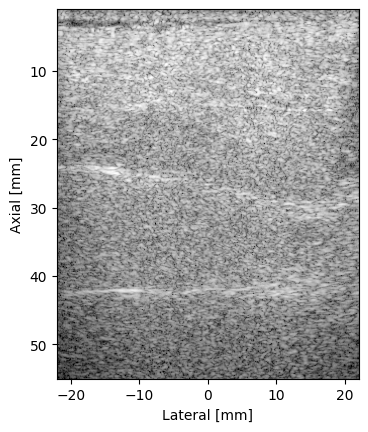

In [11]:
env = np.abs(iq_synthetic).T
logged = 20*np.log10(env/np.percentile(env, 99)+1E-10)

extent_das = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])
plt.figure()
plt.imshow(logged, vmin=-45, vmax=5, cmap='gray', extent=extent_das)
plt.xlabel("Lateral [mm]")
plt.ylabel("Axial [mm]")
plt.show()